<a href="https://colab.research.google.com/github/zb-gong/AdaptiveRegressionProj/blob/master/527_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.spatial.distance import mahalanobis

class BasicHuberRegression:
    def __init__(self, tolerance=1e-4, const_delta=1.345, max_iter=500):
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.const_delta = const_delta

    def mad(self, X):
        """ Compute the Median Absolute Deviation of x. """
        return 1.482602 * np.median(np.abs(X - np.median(X)))

    def update_huber(self, X, residual, delta):
        """ Update the gradient and derivative for Huber loss. """
        der = np.where(np.abs(residual) <= delta, -residual, -delta * np.sign(residual))
        grad = X.T @ der / len(residual)
        return der, grad

    def standardize(self, X, Y):
        """ Standardize the X and Y """
        # mean_X = np.mean(X, axis=0)
        # std_X = np.std(X, axis=0, ddof=0)
        # n_samples = X.shape[0]
        # stand_X = np.column_stack([np.ones(n_samples), (X - mean_X) / std_X])
        # stand_Y = Y - np.mean(Y)

        n_samples = X.shape[0]
        stand_X = np.column_stack([np.ones(n_samples), X])
        stand_Y = Y
        return stand_X, stand_Y

    def fit(self, X, Y, learning_rate=1.0):
        n_samples, n_features = X.shape
        stand_X, stand_Y = self.standardize(X, Y)

        # Initialize beta and gradients
        delta = self.const_delta * self.mad(stand_Y)
        beta = np.random.rand(stand_X.shape[1])
        residual = stand_Y - stand_X @ beta
        der, grad = self.update_huber(stand_X, residual, delta)

        for _ in range(self.max_iter):
            if np.linalg.norm(grad, ord=np.inf) <= self.tolerance:
                break

            beta_diff = -learning_rate * grad
            beta += beta_diff
            residual -= stand_X @ beta_diff
            der, grad = self.update_huber(stand_X, residual, delta)

        self.beta = beta

    def predict(self, X):
        """ Predict using the fitted model """
        if not hasattr(self, 'beta'):
            raise ValueError("Model has not been fitted yet. Please fit the model before predicting.")
        X = np.column_stack([np.ones(X.shape[0]), X])  # Add intercept term
        return X @ self.beta


class HuberRegression(BasicHuberRegression):
    def fit(self, X, Y):
        n_samples, n_features = X.shape
        stand_X, stand_Y = self.standardize(X, Y)

        # Initialize beta and gradients
        delta = self.const_delta * self.mad(stand_Y)
        beta = np.random.rand(stand_X.shape[1])
        residual = stand_Y - stand_X @ beta
        der, grad_new = self.update_huber(stand_X, residual, delta)
        learning_rate = 0.01

        for _ in range(self.max_iter):
            if np.linalg.norm(grad_new, ord=np.inf) <= self.tolerance:
                break

            grad_old = grad_new
            beta_diff = -learning_rate * grad_new
            beta += beta_diff
            residual -= stand_X @ beta_diff
            der, grad_new = self.update_huber(stand_X, residual, delta)

            grad_diff = grad_new - grad_old
            cross = np.dot(beta_diff, grad_diff)
            if cross > 0:
                a1 = cross / np.dot(grad_diff, grad_diff)
                a2 = np.dot(beta_diff, beta_diff) / cross
                learning_rate = min(a1, a2, 100.0)

        self.beta = beta


class AdaptiveHuberRegression(BasicHuberRegression):
    def f1(self, x, res_sq, n, rhs):
        return np.mean(np.minimum(res_sq / x, np.ones(n))) - rhs

    def rootf1(self, res_sq, n, rhs, low, up, tol=1e-4, max_ite=500):
        ite = 1
        while ite <= max_ite and up - low > tol:
            mid = 0.5 * (up + low)
            val = self.f1(mid, res_sq, n, rhs)
            if val < 0:
                up = mid
            else:
                low = mid
            ite += 1
        return 0.5 * (low + up)

    def fit(self, X, Y):
        n_samples, n_features = X.shape
        rhs = 1 / n_samples * (n_features + np.log(n_samples * n_features))
        stand_X, stand_Y = self.standardize(X, Y)

        delta = self.const_delta * self.mad(stand_Y)
        beta = np.random.rand(stand_X.shape[1])
        residual = stand_Y - stand_X @ beta
        residual_sq = residual ** 2

        delta = np.sqrt(self.rootf1(residual_sq, n_samples, rhs, np.min(residual_sq), np.sum(residual_sq)))
        der, grad_new = self.update_huber(stand_X, residual, delta)
        learning_rate = 1.0

        for _ in range(self.max_iter):
            if np.linalg.norm(grad_new, ord=np.inf) <= self.tolerance:
                break

            grad_old = grad_new
            beta_diff = -learning_rate * grad_new
            beta += beta_diff
            residual -= stand_X @ beta_diff
            residual_sq = residual ** 2

            delta = np.sqrt(self.rootf1(residual_sq, n_samples, rhs, np.min(residual_sq), np.sum(residual_sq)))
            der, grad_new = self.update_huber(stand_X, residual, delta)

            grad_diff = grad_new - grad_old
            cross = np.dot(beta_diff, grad_diff)
            if cross > 0:
                a1 = cross / np.dot(grad_diff, grad_diff)
                a2 = np.dot(beta_diff, beta_diff) / cross
                learning_rate = min(a1, a2, 100.0)

        self.beta = beta


class EnhancedAdaptiveHuberRegression(AdaptiveHuberRegression):
    def update_huber(self, X, residual, delta, weight_X):
        """ Update the gradient and derivative with weights """
        def sigmoid(z):
          return 1/(1 + np.exp(-z))
        weight_Y = np.where(np.abs(residual) <= delta, 1, delta / np.abs(residual))
        weight_combined = np.exp(weight_Y * weight_X)
        der = np.where(
            np.abs(weight_combined * residual) <= delta,
            -weight_combined * residual,
            -delta * np.sign(weight_combined * residual)
        )
        grad = (X.T @ (weight_combined * der)) / len(residual)
        return der, grad

    def _mahalanobis_distance(self, X):
        mean_vec = np.mean(X, axis=0)
        cov_matrix = np.cov(X, rowvar=False)
        cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
        inv_cov_matrix = np.linalg.pinv(cov_matrix)
        distances = np.array([mahalanobis(x, mean_vec, inv_cov_matrix) for x in X])
        return distances

    def fit(self, X, Y, anomaly_threshold=2.):
        n_samples, n_features = X.shape
        rhs = 1 / n_samples * (n_features + np.log(n_samples * n_features))
        stand_X, stand_Y = self.standardize(X, Y)

        dists = self._mahalanobis_distance(stand_X)
        weight_X = np.where(dists > anomaly_threshold, anomaly_threshold / dists, 1.0)

        delta = self.const_delta * self.mad(stand_Y)
        beta = np.random.rand(stand_X.shape[1])
        residual = stand_Y - stand_X @ beta
        residual_sq = residual ** 2

        delta = np.sqrt(self.rootf1(residual_sq, n_samples, rhs, np.min(residual_sq), np.sum(residual_sq)))
        der, grad_new = self.update_huber(stand_X, residual, delta, weight_X)
        learning_rate = 1.0

        for _ in range(self.max_iter):
            if np.linalg.norm(grad_new, ord=np.inf) <= self.tolerance:
                break

            grad_old = grad_new
            beta_diff = -learning_rate * grad_new
            beta += beta_diff
            residual -= stand_X @ beta_diff
            residual_sq = residual ** 2

            delta = np.sqrt(self.rootf1(residual_sq, n_samples, rhs, np.min(residual_sq), np.sum(residual_sq)))
            der, grad_new = self.update_huber(stand_X, residual, delta, weight_X)

            grad_diff = grad_new - grad_old
            cross = np.dot(beta_diff, grad_diff)
            if cross > 0:
                a1 = cross / np.dot(grad_diff, grad_diff)
                a2 = np.dot(beta_diff, beta_diff) / cross
                learning_rate = min(a1, a2, 100.0)

        self.beta = beta

Running simulations for noise type: normal...
Running simulations for noise type: t...
Running simulations for noise type: lognormal...

Simulation Results:
       Noise Model       Mean            SD
0     normal   OLS   1.423827  4.440892e-16
1     normal   AHR   1.423840  6.661338e-16
2     normal  EAHR   0.938522  4.440892e-16
3          t   OLS   1.050857  2.220446e-16
4          t   AHR   0.729509  1.110223e-16
5          t  EAHR   0.349186  1.110223e-16
6  lognormal   OLS  14.243869  1.776357e-15
7  lognormal   AHR   8.235826  1.776357e-15
8  lognormal  EAHR   3.754017  4.440892e-16


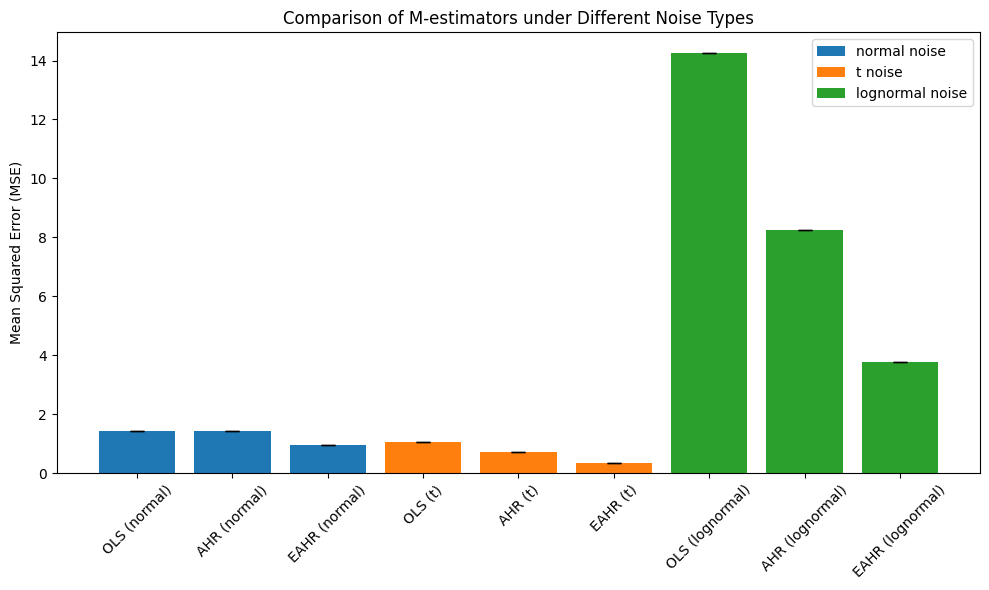

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import t as t_distribution

# Generate synthetic data
def generate_data(n, d, noise_type):
    """
    Generate synthetic data for regression.
    Parameters:
        n (int): Number of samples.
        d (int): Number of features.
        noise_type (str): Type of noise ("normal", "t", or "lognormal").
    Returns:
        X (ndarray): Feature matrix of shape (n, d).
        Y (ndarray): Response vector of shape (n,).
    """
    np.random.seed(0)
    X = np.random.normal(0, 1, size=(n, d))  # Generate X from N(0, I)
    if noise_type == "normal":
        noise = np.random.normal(0, 4, size=n)  # N(0, 4), variance = 2^2
    elif noise_type == "t":
        noise = t_distribution.rvs(1.5, size=n)  # t-distribution with df=1.5
    elif noise_type == "lognormal":
        noise = np.random.lognormal(0, 2, size=n)  # logN(0, 4)
    else:
        raise ValueError("Invalid noise type. Choose from 'normal', 't', or 'lognormal'.")
    beta_true = np.array([5, -2, 0, 0, 3] + [0] * (d - 5))
    Y_true = X @ beta_true
    Y = Y_true + noise
    return X, Y_true, Y

# Simulation parameters
n, d = 100, 5  # Number of samples and features
noise_types = ["normal", "t", "lognormal"]  # Different noise types
num_simulations = 100  # Number of simulations
results = []

for noise in noise_types:
    print(f"Running simulations for noise type: {noise}...")
    hr_errors = []  # Huber Regression errors
    ahr_errors = []  # Adaptive Huber Regression errors
    eahr_errors = []  # Enahnced Adaptive Huber Regression errors
    ols_errors = []  # Ordinary Least Squares errors

    for _ in range(num_simulations):
        X, Y_true, Y = generate_data(n, d, noise)

        # Fit Huber Regression
        hr = HuberRegression()
        hr.fit(X, Y)
        Y_pred_hr = hr.predict(X)
        hr_error = mean_squared_error(Y_true, Y_pred_hr)
        hr_errors.append(hr_error)

        # Fit Adaptive Huber Regression
        ahr = AdaptiveHuberRegression()
        ahr.fit(X, Y)
        Y_pred_ahr = ahr.predict(X)
        ahr_error = mean_squared_error(Y_true, Y_pred_ahr)
        ahr_errors.append(ahr_error)

        # Fit Enhanced Adaptive Huber Regression
        eahr = EnhancedAdaptiveHuberRegression()
        eahr.fit(X, Y)
        Y_pred_eahr = eahr.predict(X)
        eahr_error = mean_squared_error(Y_true, Y_pred_eahr)
        eahr_errors.append(eahr_error)

        # Fit Ordinary Least Squares
        ols = LinearRegression()
        ols.fit(X, Y)
        Y_pred_ols = ols.predict(X)
        ols_error = mean_squared_error(Y_true, Y_pred_ols)
        ols_errors.append(ols_error)

    # Collect mean and standard deviation of errors
    results.append({
        "Noise": noise,
        "Model": "OLS",
        "Mean": np.mean(ols_errors),
        "SD": np.std(ols_errors),
    })
    results.append({
        "Noise": noise,
        "Model": "AHR",
        "Mean": np.mean(ahr_errors),
        "SD": np.std(ahr_errors),
    })

    results.append({
        "Noise": noise,
        "Model": "EAHR",
        "Mean": np.mean(eahr_errors),
        "SD": np.std(eahr_errors),
    })

results_df = pd.DataFrame(results)
print("\nSimulation Results:")
print(results_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for noise in noise_types:
    subset = results_df[results_df["Noise"] == noise]
    plt.bar(
        subset["Model"] + " (" + noise + ")",
        subset["Mean"],
        yerr=subset["SD"],
        capsize=5,
        label=f"{noise} noise",
    )
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of M-estimators under Different Noise Types")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("adaptive_huber_vs_ols_comparison.png")
plt.show()

In [ ]:
def expr2(n, d):
  # n, d = 500, 5
  num_simulations = 20
  beta_true = np.array([5, -2, 0, 0, 3] + [0] * (d - 5))
  dfs = np.arange(1.1, 2.1, 0.05)
  ahr_results = []
  eahr_results = []
  ols_results = []

  def generate_data(n, d, df):
    np.random.seed(0)
    X = np.random.normal(0, 1, size=(n, d))  # Generate X from N(0, I)
    noise = t_distribution.rvs(df, size=n)  # t-distribution
    Y = X @ beta_true + noise
    return X, Y

  for df in dfs:
    ahr_errors = []  # Adaptive Huber Regression errors
    eahr_errors = []  # Enahnced Adaptive Huber Regression errors
    ols_errors = []  # Ordinary Least Squares errors

    for _ in range(num_simulations):
      X, Y = generate_data(n, d, df)

      # Fit Adaptive Huber Regression
      ahr = AdaptiveHuberRegression()
      ahr.fit(X, Y)
      ahr_error = mean_squared_error(beta_true, ahr.beta[1:])  # Compute MSE for AHR
      ahr_errors.append(ahr_error)

      # Fit Enhanced Adaptive Huber Regression
      eahr = EnhancedAdaptiveHuberRegression()
      eahr.fit(X, Y)
      eahr_error = mean_squared_error(beta_true, eahr.beta[1:])  # Compute MSE for EAHR
      eahr_errors.append(eahr_error)

      # Fit Ordinary Least Squares
      ols = LinearRegression()
      ols.fit(X, Y)
      ols_error = mean_squared_error(beta_true, ols.coef_)  # Compute MSE for OLS
      ols_errors.append(ols_error)

    # Collect mean and standard deviation of errors
    ols_results.append(np.mean(ols_errors))
    ahr_results.append(np.mean(ahr_errors))
    eahr_results.append(np.mean(eahr_errors))
  return ahr_results, eahr_results, ols_results

ahr_results, eahr_results, ols_results = expr2(500, 5)
ahr_results_high, eahr_results_high, ols_results_high = expr2(500, 100)


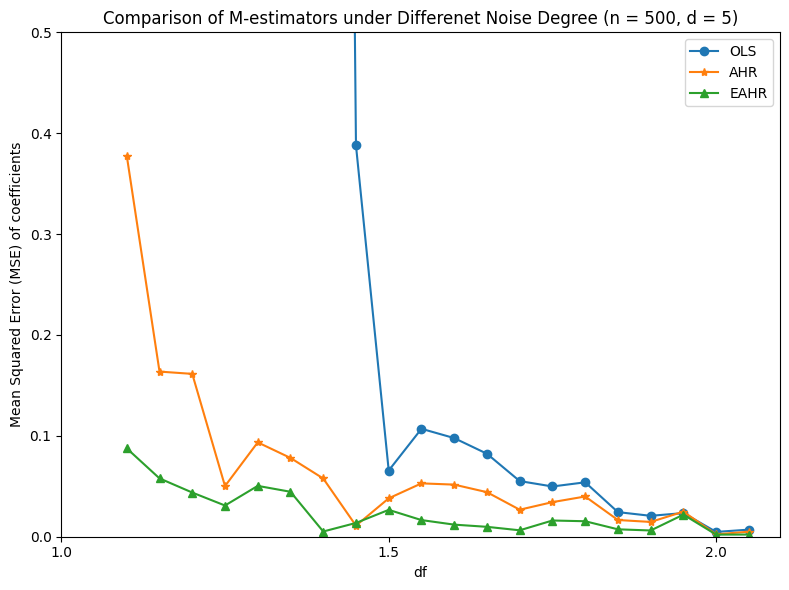

In [ ]:
import matplotlib.pyplot as plt

dfs = np.arange(1.1, 2.1, 0.05)
plt.figure(figsize=(8, 6))
plt.plot(dfs, ols_results, label = "OLS", marker = "o")
plt.plot(dfs, ahr_results, label = "AHR", marker = "*")
plt.plot(dfs, eahr_results, label = "EAHR", marker = "^")
plt.ylim(0, 0.5)
plt.xticks([1.0, 1.5, 2.0])
plt.ylabel("Mean Squared Error (MSE) of coefficients")
plt.xlabel("df")
plt.title("Comparison of M-estimators under Differenet Noise Degree (n = 500, d = 5)")
plt.legend()
plt.tight_layout()
plt.show()

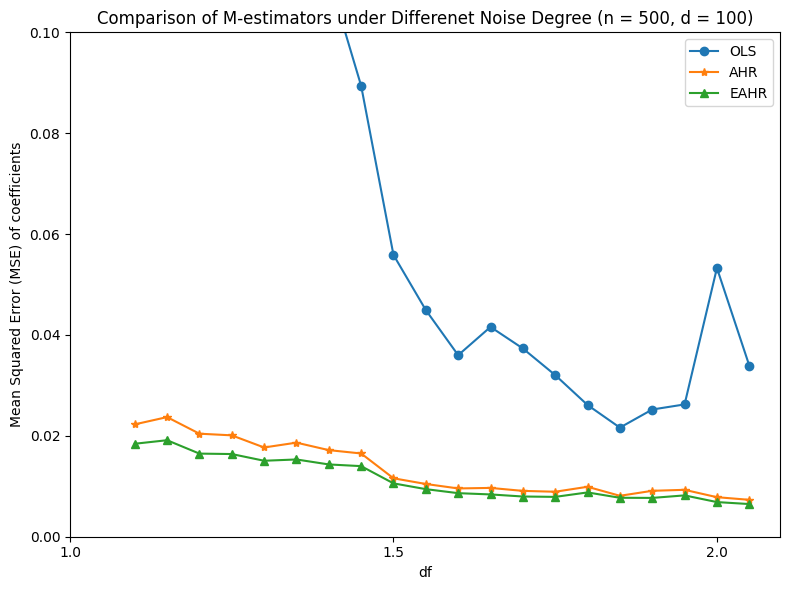

In [ ]:
dfs = np.arange(1.1, 2.1, 0.05)
plt.figure(figsize=(8, 6))
plt.plot(dfs, ols_results_high, label = "OLS", marker = "o")
plt.plot(dfs, ahr_results_high, label = "AHR", marker = "*")
plt.plot(dfs, eahr_results_high, label = "EAHR", marker = "^")
plt.ylim(0, 0.1)
plt.xticks([1.0, 1.5, 2.0])
plt.ylabel("Mean Squared Error (MSE) of coefficients")
plt.xlabel("df")
plt.title("Comparison of M-estimators under Differenet Noise Degree (n = 500, d = 100)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def add_random_anomalies(X, y, num_anomalies, feature_noise_scale=3, target_noise_scale=3):
    np.random.seed(0)
    n_samples, n_features = X.shape
    anomaly_indices = np.random.choice(n_samples, num_anomalies, replace=False)

    for idx in anomaly_indices:
        feature_idx = np.random.randint(0, n_features)
        X[idx, feature_idx] += np.random.normal(0, feature_noise_scale)
        y[idx] += np.random.normal(0, target_noise_scale)

    return X, y

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = fetch_california_housing()

X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_anomalous, y_train_anomalous = add_random_anomalies(X_train, y_train,
                                                            num_anomalies=int(0.15 * len(X_train)),
                                                            feature_noise_scale=10, target_noise_scale=10)
ols = LinearRegression()
ols.fit(X_train_anomalous, y_train_anomalous)
y_pred_ols = ols.predict(X_test)


adaptive_huber = AdaptiveHuberRegression()
adaptive_huber.fit(X_train_anomalous, y_train_anomalous)
y_pred_adaptive_huber = adaptive_huber.predict(X_test)

enhanced_adaptive_huber = EnhancedAdaptiveHuberRegression()
enhanced_adaptive_huber.fit(X_train_anomalous, y_train_anomalous)
y_pred_enhanced_adaptive_huber = enhanced_adaptive_huber.predict(X_test)


mae_ols = mean_absolute_error(y_test, y_pred_ols)
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)


mae_adaptive_huber = mean_absolute_error(y_test, y_pred_adaptive_huber)
mse_adaptive_huber = mean_squared_error(y_test, y_pred_adaptive_huber)
r2_adaptive_huber = r2_score(y_test, y_pred_adaptive_huber)

mae_enhanced_adaptive_huber = mean_absolute_error(y_test, y_pred_enhanced_adaptive_huber)
mse_enhanced_adaptive_huber = mean_squared_error(y_test, y_pred_enhanced_adaptive_huber)
r2_enhanced_adaptive_huber = r2_score(y_test, y_pred_enhanced_adaptive_huber)

print("\nOLS MAE:", mae_ols)
print("OLS MSE:", mse_ols)
print("OLS R^2:", r2_ols)

print("\nAdaptive Huber MAE:", mae_adaptive_huber)
print("Adaptive Huber MSE:", mse_adaptive_huber)
print("Adaptive Huber R^2:", r2_adaptive_huber)

print("\nEnhanced Adaptive Huber MAE:", mae_enhanced_adaptive_huber)
print("Enhanced Adaptive Huber MSE:", mse_enhanced_adaptive_huber)
print("Enhanced Adaptive Huber R^2:", r2_enhanced_adaptive_huber)


OLS MAE: 0.6625314430330035
OLS MSE: 0.7445921430463806
OLS R^2: 0.431786445750757

Adaptive Huber MAE: 0.6546273003099164
Adaptive Huber MSE: 0.7313450987025095
Adaptive Huber R^2: 0.4418955373121213

Enhanced Adaptive Huber MAE: 0.6123963594889957
Enhanced Adaptive Huber MSE: 0.6572110460481736
Enhanced Adaptive Huber R^2: 0.4984687552046405
